### Analyses of motor behavior at profficiency
Jun2023 \
author: Inês Laranjeira

Analyses of different metrics, hypothesized to be stereotyped throughout learning.

Instructed movements:
- licking
- wheel movement

Uninstructed movements:
- gaze (uninstructed but likely related modulated by stimulus presentation)
- pupil size
- body movement
- whisking

In [1]:
"""
IMPORTS
"""
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os
import re
from mpl_toolkits.mplot3d import Axes3D

from brainbox.task.trials import find_trial_ids
from brainbox.behavior.training import get_sessions, get_training_status
from brainbox.io.one import load_wheel_reaction_times
import brainbox.behavior.wheel as wh
from ibllib.io.extractors.ephys_fpga import extract_wheel_moves
from ibllib.io.extractors.training_wheel import extract_first_movement_times
from one.api import ONE

one = ONE()

# --Machine learning and statistics
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.model_selection import cross_validate, train_test_split, cross_val_score, KFold, cross_val_predict
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Get my functions
functions_path = "../Functions/"
os.chdir(functions_path)
from one_functions_generic import query_subjects_interest, subjects_interest_data, prepro

## Functions
### Need to move to separate file

In [4]:
def stack_trials(time, position, trials, event, t_init, t_end):

    wheel_df = pd.DataFrame({'time':time, 'position':position})
    onset_times = trials[event]
    # Start a matrix with #trials x # wheel bins
    wheel_stack = np.zeros((len(onset_times), 500)) * np.nan  # TODO: should not be hard-coded

    for t, trial_onset in enumerate(onset_times):
        if np.isnan(trial_onset) == False:
            if len(wheel_df.loc[wheel_df['time'] > trial_onset, 'time']) > 0:
                trial_onset_index = wheel_df.loc[wheel_df['time'] > trial_onset, 'time'].reset_index()['index'][0]
                onset_position = wheel_df['position'][trial_onset_index]
                #trial_feedback = list(preprocessed_data['correct'])[t]

                # Populate dataframe with useful trial-aligned information
                wheel_stack[t, :] = wheel_df.loc[(wheel_df['time']> trial_onset-t_init) & (wheel_df['time'] <= trial_onset+t_end), 'position'] - onset_position 
    return wheel_stack

## Get training data

In [5]:
# Get subjects of interest
subjects_of_interest = query_subjects_interest(protocol='training', ibl_project='ibl_neuropixel_brainwide_01')
#data = subjects_interest_data(subjects_of_interest)
data = subjects_interest_data(['KS014'], phase='proficient')

## Load wheel data

In [6]:
sessions = data['session'].unique()
t_init = 0  # time to plot before stimulus onset
t_end = 0.5 # time to plot after stimulus onset

all_wheel = pd.DataFrame()
# Loop through sessions (could put this inside an animal loop)
for s, session in enumerate(sessions[0:1]):
    # Get session data
    eid = '4ecb5d24-f5cc-402c-be28-9d0f7cb14b3a'
    eid = session
    wheel = one.load_object(eid, 'wheel', collection='alf')
    wheelMoves = one.load_object(eid, 'wheelMoves', collection='alf')
    trials_data = data.loc[data['session']==eid]
    processed_data = prepro(trials_data)

    # Get wheel data for that session
    pos, time = wh.interpolate_position(wheel.timestamps, wheel.position)

    wheel_stack = pd.DataFrame(stack_trials(time=time, position=pos, trials=processed_data, event='stimOn_times', t_init = 0, t_end = 0.5))
    
    if s == 0:
        all_wheel = wheel_stack.copy()
        all_wheel['mouse_name'] = 'KS014'  #TODO: make this not hard-coded
        #all_wheel['session_number'] = s + 1
        all_wheel['feedback'] = list(processed_data['correct'])
        all_wheel['choice'] = list(processed_data['choice'])
        all_wheel['contrast'] = list(processed_data['contrast'])
    else:
        wheel_stack['mouse_name'] = 'KS014'  #TODO: make this not hard-coded
        #wheel_stack['session_number'] = s + 1
        wheel_stack['feedback'] = list(processed_data['correct'])
        wheel_stack['choice'] = list(processed_data['choice'])
        wheel_stack['contrast'] = list(processed_data['contrast'])
        all_wheel = all_wheel.append(wheel_stack)


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/one_functions_generic.py:487: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['contrastLeft'] = trials['contrastLeft'].fillna(0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/one_functions_generic.py:488: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['contrastRight'] = trials['contrastRight'].fillna(0)
/Users/ineslaranjeira/Documents/Repositories/representation_

## Plot wheel movements

In [7]:
melted = pd.melt(all_wheel, id_vars=['mouse_name', 'feedback', 'choice', 'contrast'], value_vars=np.array(all_wheel.keys()[1:-4]))

In [27]:
data_correct = melted.loc[(melted['contrast']==1) & (melted['feedback']==1.0)]

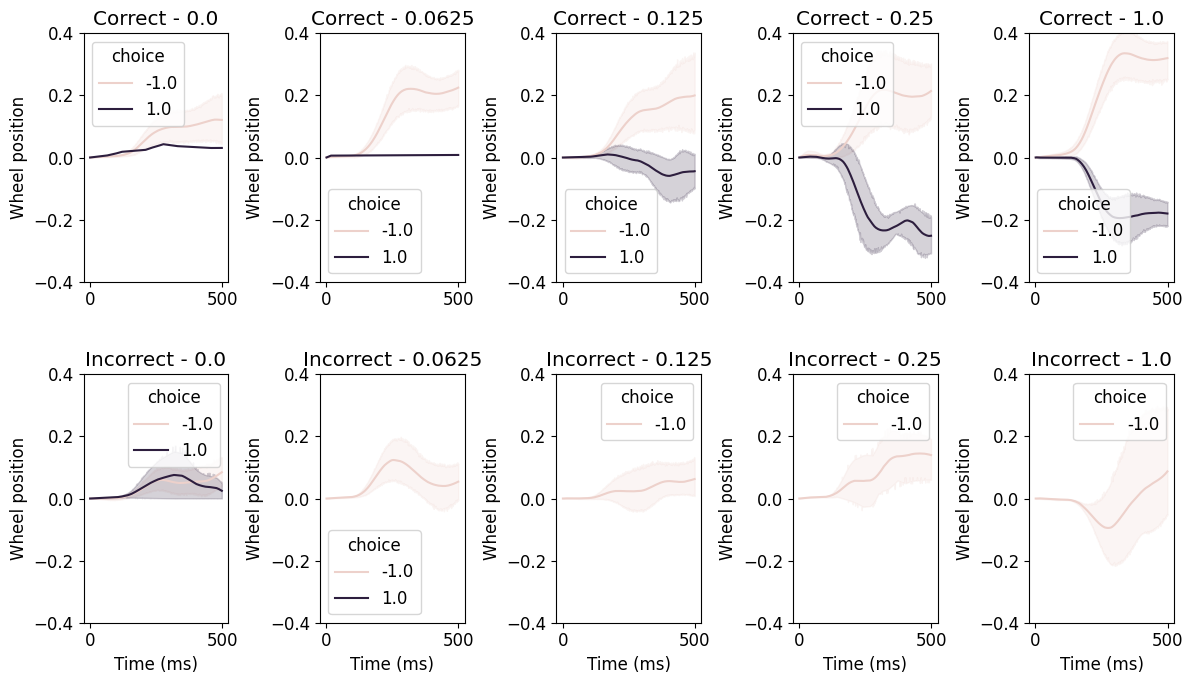

In [29]:
contrasts = melted.contrast.unique()
contrasts.sort()

fig, ax = plt.subplots(nrows=2, ncols=len(contrasts), sharex=False, sharey=False, figsize=[12, 7])

plt.rc('font', size=12)

for c, contrast in enumerate(contrasts):
    
    data_correct = melted.loc[(melted['contrast']==contrast) & (melted['feedback']==1.0)]
    data_incorrect = melted.loc[(melted['contrast']==contrast) & (melted['feedback']==0.0)]

    sns.lineplot(x='variable', y='value', hue='choice', data=data_correct, ax = ax[0, c])
    sns.lineplot(x='variable', y='value', hue='choice', data=data_incorrect, ax = ax[1, c])

    ax[0,c].set_xlabel(' ')
    ax[1,c].set_xlabel('Time (ms)')
    ax[0,c].set_ylabel('Wheel position')
    ax[1,c].set_ylabel('Wheel position')
    ax[0, c].set_ylim([-.4, .4])
    ax[1, c].set_ylim([-.4, .4])

    ax[0,c].set_title(str('Correct - ' + str(contrast)))
    ax[1,c].set_title(str('Incorrect - ' + str(contrast)))

plt.tight_layout()